In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import math
import copy
import numpy as np
import time
import matplotlib.pyplot as plt

# 封装随机种子函数
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# 设置设备
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"当前运行设备: {DEVICE}")
set_seed(42)

当前运行设备: cuda


In [2]:
class VehicleDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.img_paths)
    def __getitem__(self, idx):
        try:
            image = Image.open(self.img_paths[idx]).convert('RGB')
            if self.transform: image = self.transform(image)
            return image, self.labels[idx]
        except: 
            # 返回一个黑色的227x227图片防止报错
            return torch.zeros((3, 227, 227)), self.labels[idx]

def get_alexnet_data_loaders(data_root, batch_size=16):
    """
    专门为 AlexNet 适配的数据加载函数，强制 Resize 为 227x227
    """
    # AlexNet 标准输入尺寸
    target_h, target_w = 227, 227
    valid_ext = ('.jpg', '.png', '.jpeg')
    
    # 定义 Transform 
    # 训练集：加入数据增强
    train_transform = transforms.Compose([
        transforms.Resize((target_h, target_w)), # 强制调整为 227x227
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    # 测试集：仅缩放和归一化
    test_transform = transforms.Compose([
        transforms.Resize((target_h, target_w)), # 强制调整为 227x227
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    
    # 划分数据 
    classes = ['bus', 'car', 'truck']
    class_map = {n: i for i, n in enumerate(classes)}
    train_paths, train_lbls, test_paths, test_lbls = [], [], [], []
    
    for cls in classes:
        cls_dir = os.path.join(data_root, cls)
        if not os.path.exists(cls_dir): continue
        imgs = [os.path.join(cls_dir, x) for x in os.listdir(cls_dir) if x.lower().endswith(valid_ext)]
        np.random.shuffle(imgs)
        split = int(len(imgs) * 0.2) # 20% 做测试
        
        test_paths.extend(imgs[:split]); test_lbls.extend([class_map[cls]]*len(imgs[:split]))
        train_paths.extend(imgs[split:]); train_lbls.extend([class_map[cls]]*len(imgs[split:]))
    
    train_ds = VehicleDataset(train_paths, train_lbls, train_transform)
    test_ds = VehicleDataset(test_paths, test_lbls, test_transform)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    print(f"数据加载完成: 训练集 {len(train_ds)} 张, 测试集 {len(test_ds)} 张")
    return train_loader, test_loader

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=3):
        super(AlexNet, self).__init__()
        
        # 特征提取层 (5个卷积层)
        self.features = nn.Sequential(
            # Layer 1: 
            # Input: 227x227x3 -> Conv(11x11, s=4) -> 55x55x96 -> MaxPool(3x3, s=2) -> 27x27x96
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Layer 2: Same Padding
            # Input: 27x27x96 -> Conv(5x5, s=1, p=2) -> 27x27x256 -> MaxPool(3x3, s=2) -> 13x13x256
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Layer 3: Same Padding
            # Input: 13x13x256 -> Conv(3x3, s=1, p=1) -> 13x13x384
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Layer 4: Same Padding
            # Input: 13x13x384 -> Conv(3x3, s=1, p=1) -> 13x13x384
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # Layer 5: Same Padding
            # Input: 13x13x384 -> Conv(3x3, s=1, p=1) -> 13x13x256 -> MaxPool(3x3, s=2) -> 6x6x256
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # 展平后的维度计算：256 * 6 * 6 = 9216
        
        # 分类器层 (3个全连接层)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            # 输出层：改为3分类
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # 展平操作
        x = torch.flatten(x, 1) 
        x = self.classifier(x)
        return x

# 打印模型结构验证
model_test = AlexNet(num_classes=3)
print(model_test)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
 

In [ ]:
def train_model(model, train_loader, test_loader, lr=0.001, epochs=50, patience=5, device=DEVICE, name="Experiment"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    
    history = {'loss': [], 'train_acc': [], 'test_acc': [], 'time': [], 'name': name}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    patience_counter = 0
    
    print(f"\n开始实验: {name} | LR={lr} | Device={device}")
    start_time = time.time()
    
    for epoch in range(epochs):
        ep_start = time.time()
        
        # 1. 训练阶段
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, lbls)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += lbls.size(0)
            correct_train += (preds == lbls).sum().item()
            
        # 2. 验证/测试阶段
        model.eval()
        correct_test = 0
        total_test = 0
        test_running_loss = 0.0
        
        with torch.no_grad():
            for imgs, lbls in test_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, lbls)
                
                test_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total_test += lbls.size(0)
                correct_test += (preds == lbls).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_test_loss = test_running_loss / len(test_loader)
        
        train_acc = 100 * correct_train / total_train
        test_acc = 100 * correct_test / total_test
        ep_duration = time.time() - ep_start
        
        history['loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['time'].append(ep_duration)
        
        print(f"[{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_acc:.2f}%")
        
        # 早停
        if avg_test_loss < best_loss:
            best_loss = avg_test_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"早停触发！在第 {epoch+1} 轮停止。最佳 Test Loss: {best_loss:.4f}")
            break
            
    total_time = time.time() - start_time
    print(f"实验 {name} 结束. 总耗时: {total_time:.2f}s")
    
    model.load_state_dict(best_model_wts)
    return history

def plot_comparison(results_list):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for res in results_list:
        plt.plot(res['loss'], label=res['name'] + ' Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    for res in results_list:
        plt.plot(res['test_acc'], label=res['name'] + ' Acc')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

数据加载完成: 训练集 1087 张, 测试集 270 张

开始实验: AlexNet | LR=0.0001 | Device=cuda
[1/30] Train Loss: 0.8051 | Test Loss: 0.5823 | Test Acc: 72.96%
[2/30] Train Loss: 0.4798 | Test Loss: 0.4594 | Test Acc: 79.26%
[3/30] Train Loss: 0.3805 | Test Loss: 0.3316 | Test Acc: 86.30%
[4/30] Train Loss: 0.2946 | Test Loss: 0.3278 | Test Acc: 87.78%
[5/30] Train Loss: 0.2700 | Test Loss: 0.2862 | Test Acc: 88.89%
[6/30] Train Loss: 0.2343 | Test Loss: 0.2632 | Test Acc: 89.26%
[7/30] Train Loss: 0.2115 | Test Loss: 0.2293 | Test Acc: 92.59%
[8/30] Train Loss: 0.2155 | Test Loss: 0.2634 | Test Acc: 91.11%
[9/30] Train Loss: 0.1826 | Test Loss: 0.1790 | Test Acc: 92.96%
[10/30] Train Loss: 0.1575 | Test Loss: 0.1617 | Test Acc: 94.07%
[11/30] Train Loss: 0.1358 | Test Loss: 0.1855 | Test Acc: 93.33%
[12/30] Train Loss: 0.1287 | Test Loss: 0.2376 | Test Acc: 91.48%
[13/30] Train Loss: 0.1136 | Test Loss: 0.2166 | Test Acc: 92.96%
[14/30] Train Loss: 0.1152 | Test Loss: 0.2022 | Test Acc: 93.70%
[15/30] Train 

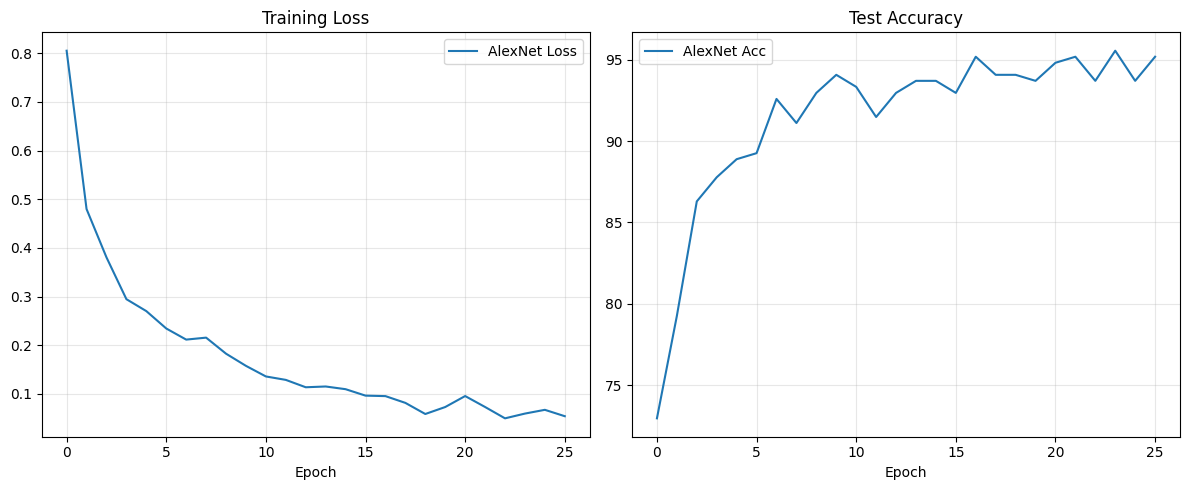

In [5]:
# 路径设置 (根据实际情况修改)
DATA_ROOT = './cardata' 

# 1. 获取数据 (使用 AlexNet 专用 Loader)
train_loader, test_loader = get_alexnet_data_loaders(DATA_ROOT, batch_size=32)

# 2. 初始化模型
set_seed(42)
alexnet_model = AlexNet(num_classes=3)

# 3. 开始训练
# AlexNet参数多，容易过拟合或梯度震荡，这里使用较小的学习率 0.0001
history_alexnet = train_model(
    alexnet_model, 
    train_loader, 
    test_loader, 
    lr=0.0001, 
    epochs=30, 
    patience=5, 
    name="AlexNet"
)

# 4. 绘图
plot_comparison([history_alexnet])

In [9]:
torch.save(alexnet_model.state_dict(), 'alexnet_vehicle.pth')
import json

# 假设 history_alexnet 是你训练得到的字典
# 保存到 history.json 文件
with open('history_alexnet.json', 'w') as f:
    json.dump(history_alexnet, f)

print("训练历史已保存为 history_alexnet.json")

训练历史已保存为 history_alexnet.json


In [ ]:
set_seed(42) # 保持一致性
new_model = AlexNet(num_classes=3)
new_model.load_state_dict(torch.load('alexnet_best.pth'))
new_model.to(DEVICE)
new_model.eval()
with open('history_alexnet.json', 'r') as f:
    loaded_history = json.load(f)

print("历史数据读取成功！")